<a href="https://colab.research.google.com/github/Jahan2021/UCS-Classification/blob/main/Classic_DL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is reproduced from: https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

## Method
We will use Dense text classifier , Long Short Term Memory(LSTM) and Bi-directional LSTM and compare these methods in terms of performance and runtime. 

The work here is broken down in multiple steps:

* Load and explore the data
* Prepare train test data
* Train the detection model using the three approaches mentioned earlier
* Select one as a final model
* Use the final trained classifier to classify the text


First, let's make sure our tensorflow version is 2. 

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


Next, let's import packages that we need. It's good practice to keep all the imports at the beginning of the code. In any project, as you work through the analysis and find you need to import a package, make sure to add the import up here at the benginning.

In [ ]:
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional


## Load and explore the UCS data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/Colab Notebooks"

In [ ]:
path_data=path+"/data1/ucsdata.csv"#"/content/spamdata_v2.csv"#"/content/spamdata_v2.txt"
df = pd.read_csv(path_data)
df.head()


,label,text
0,1,the user uses the find filter and select capab...
1,1,a map based query can be performed.
2,1,user finds and selects the desired structure s.
3,1,user views data for the selected structure s.
4,1,the user uses the find filter and select capab...


In [ ]:
df.shape

(1447, 2)

In [ ]:
df=df.drop_duplicates(keep='last', ignore_index=True)

In [ ]:
# Selecting duplicate rows except first 
# occurrence based on all columns
duplicate = df[df.duplicated()]
  
print("Duplicate Rows :")
  
# Print the resultant Dataframe
duplicate
#df.drop_duplicates()

Duplicate Rows :


,label,text


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,label,text
0,1,user selects to expand selected nodes.
1,1,system removes the selected nodes from the dis...
2,0,digitalhomeowner director will provide managem...
3,1,a new item can be added to the list by cloning...
4,0,item in the database.


In [ ]:
df_not_usecase = df[df['label']==0]
df_not_usecase.shape

(738, 2)

In [ ]:
df_usecase = df[df['label']==1]
df_usecase.shape

(582, 2)

In [ ]:
#down sample the dataset to make it balanced
df_not_usecase_downsampled = df_not_usecase.sample(df_usecase.shape[0])
df_not_usecase_downsampled.shape

(582, 2)

In [ ]:
df_balanced = pd.concat([df_not_usecase_downsampled, df_usecase])
df_balanced.shape

(1164, 2)

In [ ]:
df_balanced['label'].value_counts()

1    582
0    582
Name: label, dtype: int64

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# turn a doc into clean tokens
def clean_doc(doc):
  doc = doc.lower()
  # split into tokens by white space
  tokens = doc.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  #stop_words = set(stopwords.words('english'))
  #tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return  (" ".join(tokens)).strip()+'.'

In [ ]:
import string
df_balanced["text"]=df_balanced["text"].apply(lambda x: clean_doc(x))
#df[1] = df[1].apply(add_one)

In [ ]:
df_balanced.head()

,label,text
1099,0,users shall have high level of sophistication ...
428,0,net framework and asp.
286,0,this section of the report outlines the functi...
533,0,non behavioral requirements which includes per...
1221,0,the test and verification team can reference t...


In [ ]:
msg_df=df_balanced

## Prepare train test data and pre-processing text
First, we need to convert the text label to numeric and split the data into training set and testing set. Also, convert label to numpy arrays to fit deep learning models. 80% of data were used for training and 20% for testing purposes. 

In [ ]:
# Split data into train and test
#train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
#val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                #random_state=2018, 
                                                                #test_size=0.5, 
                                                                #stratify=temp_labels)

In [ ]:
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['text'], msg_df['label'], test_size=0.3, random_state=2018,stratify=msg_df['label'])

In [ ]:
print(train_msg[:2])

357     user manages the administration functionalitie...
1066    the screens used for the acquisition process s...
Name: text, dtype: object


Below, define the pre-processing hyperparameters and prepare data for training. Particularly we'll use text pre-processing which include:
- Tokenization
- Sequencing
- Padding



#### Tokenization
As deep learning models do not understand text, we need to convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer will do all required pre-processing such as 
- tokenize into word or charachter - here its at word level
- num_words for maximum number of unique tokens hence we can filter out rare words
- filter out punctuation terms
- convert all words to lower case
- convert all words to integer index

Below, let's define hyper-parameters used for Tokenization. These hyper-parmaters are briefly discussed as we use these in the code. 

In [ ]:
# Defining pre-processing hyperparameters
max_len = 60 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

Hyper-parameters used in Tokenizer object are: num_words and oov_token. 
* num_words: indicate how many unique word you want to load in training and testing data. For our purpose, we selected 500 words (vocab_size)
* oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
word_index

In [ ]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 1771 unique tokens in training data. 


#### Sequencing and Padding

Once tokenization is done, let's represent each sentence by sequences of numbers using texts_to_sequences from tokenizer object. Subsequently, we padded the sequence so that we can have same length of each sequence.  Sequencing and padding are done for both training and testing data.

In [ ]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

- padding = 'pre' or 'post (default pre). By using pre, we'll pad before each sequence and post will pad after each sequence.
- maxlen = maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence.
- truncating = 'pre' or 'post' (default 'pre'). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. 'pre' option will truncate at the beginning where as 'post' will truncate at the end of the sequences.

In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (814, 60)
Shape of testing tensor:  (350, 60)


In [ ]:
# Before padding : first sequence is 27 character long where as second one is 24
len(training_sequences[0]), len(training_sequences[1])

(9, 30)

In [ ]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(60, 60)

In [ ]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[  7   1   2   1 374  13   1  18 133   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


## Train the Model

#### Dense UCS Detection Architechture

Below is a model architecture of dense spam detection model. 

- Sequential calls for Keras sequential model in which layers are added in a sequence
- The first layer i.e. embedding layer maps each word to a N-dimensional vector of real numbers. The embeding_dim is the size of this vector which is 16 in our case. The embeding layer indicates that the two words with similar meaning tend to have very close vectors. Because, the embedding layer is the first hiddne layer in our model network, we need to pass shape of our input layer as defined by input_length (max_len =50).
- The pooling layer helps to reduce the number of parameters in the model hence helps to avoid overfitting. We have used average pooling here and coverted layer to 1 dimension.

- Next we used a dense layer with activation function 'relu' followed by a dropout layer to avoid overfitting and a final outpout layer with sigmoid activation function. As there are only two classes (ham or spam) to classify, we used only a single output neuron. The sigmoid activation function outputs probabilities between 0 and 1. 

- Here, we used fairly a shallow neural network architecture, however, you can  make it more dense adding more layers.

In [ ]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [ ]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

The model.summary() provides the layer, shape and number of parameters used in each layer. In the embedding layer, the 8000 parameter comes from 500 words (vocab_size), each one with a 16 dimensional word-vector space (500 X 16 = 8000). The embedding layer is passed through GlobalAveragePooling1D  and into dense layers have shape of 16 (due to the avereage pooling along 16 embedding dimension). We selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the dense layer gets input from each of the 16 values coming from the GlobalAveragePooling1D layer, for a total of 384 (16 X 24) weights and 24 biases (one for each 24 neurons). Hence the total parameter is 408. Finally, the output layer has 24 weights (one for each neuron) and its bias resulting 25 parameters. 

In [ ]:
dense_model=model

In [ ]:
dense_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 16)            8000      
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

Let's compile our dense spam classifier model. We used 'binary_crossentropy' as a loss function because of binary output. We used 'adam' as an optimiser which makes use of  momentum to avoid local minima and 'accuracy' as a measure of model performance. 

In [ ]:
# Compile model
#from tensorflow import keras
# Using Adam optimiser which makes use of momentum to avoid local minima
#optim = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
dense_model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Next let's fit our dense classifier using model.fit argument. It uses padded training data and training labels for training the model and validation data for validating. 

* Epoch: Number of times the learning algorithm will work through the entire training data set. We set it to be 20. 
* callbacks: callbacks is used to pass the early stopping parameter. EarlyStopping(monitor='val_loss', patience=2) was used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit. 
* verbose =2: lets to print loss and accuracy on each epoch

In [ ]:
import time

In [ ]:
# fitting a dense spam detector model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
start=time.time()
dense_history = dense_model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
end =time.time()
print("Total time for Dense:"+str(end-start))

Epoch 1/50
26/26 - 1s - loss: 0.6942 - accuracy: 0.4988 - val_loss: 0.6921 - val_accuracy: 0.5000 - 1s/epoch - 40ms/step
Epoch 2/50
26/26 - 0s - loss: 0.6913 - accuracy: 0.5663 - val_loss: 0.6891 - val_accuracy: 0.8286 - 206ms/epoch - 8ms/step
Epoch 3/50
26/26 - 0s - loss: 0.6873 - accuracy: 0.6916 - val_loss: 0.6848 - val_accuracy: 0.8114 - 160ms/epoch - 6ms/step
Epoch 4/50
26/26 - 0s - loss: 0.6817 - accuracy: 0.7236 - val_loss: 0.6773 - val_accuracy: 0.7971 - 223ms/epoch - 9ms/step
Epoch 5/50
26/26 - 0s - loss: 0.6712 - accuracy: 0.7641 - val_loss: 0.6645 - val_accuracy: 0.7943 - 199ms/epoch - 8ms/step
Epoch 6/50
26/26 - 0s - loss: 0.6507 - accuracy: 0.7961 - val_loss: 0.6426 - val_accuracy: 0.8429 - 198ms/epoch - 8ms/step
Epoch 7/50
26/26 - 0s - loss: 0.6242 - accuracy: 0.8366 - val_loss: 0.6109 - val_accuracy: 0.8457 - 203ms/epoch - 8ms/step
Epoch 8/50
26/26 - 0s - loss: 0.5887 - accuracy: 0.8428 - val_loss: 0.5751 - val_accuracy: 0.8657 - 199ms/epoch - 8ms/step
Epoch 9/50
26/26 -

In [ ]:
# Model performermance on test data is about 9465% accuracy with validation loss of 0.11.
dense_model.evaluate(testing_padded, test_labels)

11/11 [==============================] - 0s 5ms/step - loss: 0.2158 - accuracy: 0.9143


[0.21580331027507782, 0.9142857193946838]

In [ ]:
dense_metrics = pd.DataFrame(dense_history.history)
dense_metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.694223,0.498771,0.692095,0.500000
1,0.691264,0.566339,0.689131,0.828571


In [ ]:
# Rename column
dense_metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
dense_metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.694223,0.498771,0.692095,0.500000
1,0.691264,0.566339,0.689131,0.828571


In [ ]:
def plot_graphs1(var1, var2, string):
    dense_metrics[[var1, var2]].plot()
    plt.style.use('seaborn')
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    plt.savefig(path+'/data1/dense_acc.png')

In [ ]:
#dense_metrics=metrics

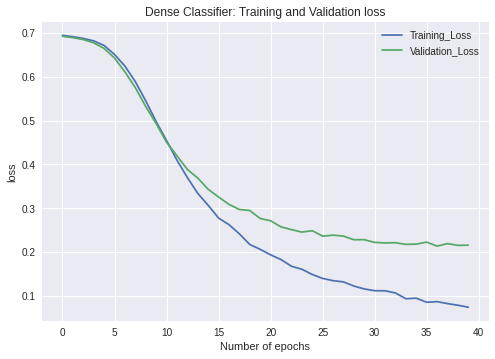

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.savefig('dense_loss.png')

In [ ]:
plt.savefig('dense_loss.png')

<Figure size 576x396 with 0 Axes>

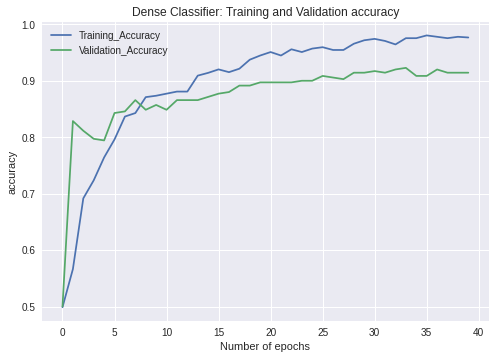

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
plt.savefig('dense_acc.png')

<Figure size 576x396 with 0 Axes>

In [ ]:
#y_test=np.argmax(preds,axis=1)
#y_predict = np.argmax(model.predict(testing_padded), axis=-1)

In [ ]:
from sklearn.metrics import classification_report
#testing_padded, test_labels
y_pred = dense_model.predict(testing_padded)
y = np.array([0 if x < 0.5 else 1 for x in y_pred])
#preds = np.argmax(y_pred, axis = 1)
#print(y_pred)
#print(y)
print(classification_report(test_labels, y))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       175
           1       0.94      0.89      0.91       175

    accuracy                           0.91       350
   macro avg       0.92      0.91      0.91       350
weighted avg       0.92      0.91      0.91       350



In [ ]:
#df_rep = pd.DataFrame(report,False).transpose()
#df_rep.to_csv('test.csv',sep=',')

In [ ]:
from sklearn.metrics import confusion_matrix

#print(classification_report(test_labels,))

print(confusion_matrix(test_labels, y))


[[165  10]
 [ 20 155]]


In [ ]:
preds = dense_model.predict(testing_padded,verbose=1)

11/11 [==============================] - 0s 2ms/step


In [ ]:
from sklearn import metrics
targets=test_labels
dist_fpr1, dist_tpr1, dist_thresh1 = metrics.roc_curve(targets, preds, pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(targets))]
p_fpr, p_tpr, _ = metrics.roc_curve(targets, random_probs, pos_label=1)
auc_score1_dist = metrics.roc_auc_score(targets, preds)

In [ ]:
print(auc_score1_dist)

0.9726040816326531


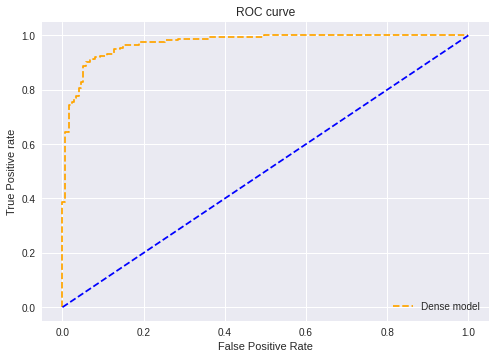

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(dist_fpr1, dist_tpr1, linestyle='--',color='orange', label='Dense model')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Long Short Term Memory (LSTM) layer architecture 

Below, we fit the spam detection model using LSTM. Some new hyper-parameters used in LSTM below are SpatialDropout1D and n_lstm. 
* SpatialDropout1D is used to dropout our embedding layer by using drop_embed =0.2. The SpatialDropout1D helps to drop entire 1D feature maps instead of individual elements.  
* n_lstm 128 is the number of nodes in the hidden layers within the LSTM cell
* return_sequences=True ensures that the LSTM cell returns all of the outputs from the unrolled LSTM cell through time. If this argument is not used, the LSTM cell will simply provide the output of the LSTM cell from the previous step.

In [ ]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [ ]:
#LSTM UCS detection architecture
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
lstm_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Training
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=2)
start=time.time()
lstm_history = lstm_model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
end=time.time()
print("Total time for LSTM "+str(end-start))

Epoch 1/50
26/26 - 6s - loss: 0.6932 - accuracy: 0.5288 - val_loss: 0.6904 - val_accuracy: 0.6110 - 6s/epoch - 227ms/step
Epoch 2/50
26/26 - 1s - loss: 0.6661 - accuracy: 0.6635 - val_loss: 0.6414 - val_accuracy: 0.6588 - 770ms/epoch - 30ms/step
Epoch 3/50
26/26 - 1s - loss: 0.4516 - accuracy: 0.8415 - val_loss: 0.3968 - val_accuracy: 0.8635 - 773ms/epoch - 30ms/step
Epoch 4/50
26/26 - 1s - loss: 0.3366 - accuracy: 0.8949 - val_loss: 0.4658 - val_accuracy: 0.8301 - 768ms/epoch - 30ms/step
Epoch 5/50
26/26 - 1s - loss: 0.3202 - accuracy: 0.8957 - val_loss: 0.4077 - val_accuracy: 0.8770 - 750ms/epoch - 29ms/step
Total time for LSTM 9.056631565093994


In [ ]:
# Create a dataframe
lstm_metrics = pd.DataFrame(lstm_history.history)

# Rename column
lstm_metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    lstm_metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

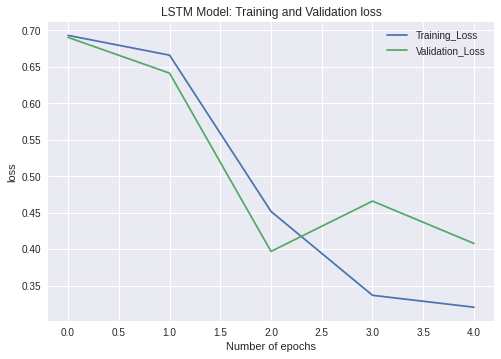

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [ ]:
plt.savefig('lstm_loss.png')

<Figure size 576x396 with 0 Axes>

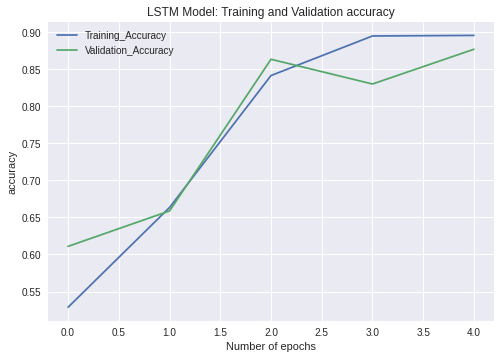

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
plt.savefig('lstm_acc.png')

<Figure size 576x396 with 0 Axes>

In [ ]:
# Model performermance on test data is about 91% accuracy with validation loss of 0.29.
result=lstm_model.evaluate(testing_padded, test_labels)

11/11 [==============================] - 0s 13ms/step - loss: 0.4077 - accuracy: 0.8770


In [ ]:
result

[0.40774527192115784, 0.877000093460083]

In [ ]:
from sklearn.metrics import classification_report
#testing_padded, test_labels
y_pred = lstm_model.predict(testing_padded)

In [ ]:
y_pred.shape

(350, 60, 1)

In [ ]:
y = np.array([0 if x < 0.5 else 1 for x in y_pred[:,1]])
#y = np.argmax(y_pred, axis = 1)
#print(y_pred)
print(y)


[0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1
 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1
 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0
 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0
 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0
 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1
 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1]


In [ ]:
print(classification_report(test_labels, y))

              precision    recall  f1-score   support

           0       0.85      0.55      0.67       175
           1       0.67      0.90      0.77       175

    accuracy                           0.73       350
   macro avg       0.76      0.73      0.72       350
weighted avg       0.76      0.73      0.72       350



In [ ]:
preds1 = lstm_model.predict(testing_padded,verbose=1)

11/11 [==============================] - 0s 11ms/step


In [ ]:
from sklearn import metrics
targets=test_labels
dist_fpr1, dist_tpr1, dist_thresh1 = metrics.roc_curve(targets, preds1[:,0], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(targets))]
p_fpr, p_tpr, _ = metrics.roc_curve(targets, random_probs, pos_label=1)
auc_score1_dist = metrics.roc_auc_score(targets, preds1[:,0])

In [ ]:
print(auc_score1_dist)

0.846465306122449


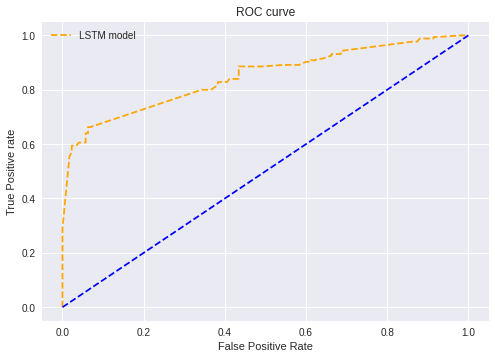

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(dist_fpr1, dist_tpr1, linestyle='--',color='orange', label='LSTM model')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Biderectional LSTM (Bi-LSTM) Spam detection architecture
Unlike in LSTM, the Bi-LSTM learns patterns from both before and after a given token within a document. The Bi-LSTM backpropagates in both backward and forward directions in time.  Due to this, the computational time is increased compared to LSTM. However, in most of the cases Bi-LSTM results in better accuracy. 

Below, we can see the Bi-derectional LSTM architechure where only difference than LSTM is that we use Bidirectional wrapper to LSTM. 

In [ ]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
bilstm_model=model2

In [ ]:
# Training
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=2)
start=time.time()
bilstm_history = bilstm_model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
end=time.time()
print("Total time for BiLSTM "+str(end-start))

Epoch 1/50
26/26 - 6s - loss: 0.6936 - accuracy: 0.4983 - val_loss: 0.6919 - val_accuracy: 0.5069 - 6s/epoch - 218ms/step
Epoch 2/50
26/26 - 1s - loss: 0.6905 - accuracy: 0.5648 - val_loss: 0.6865 - val_accuracy: 0.5827 - 752ms/epoch - 29ms/step
Epoch 3/50
26/26 - 1s - loss: 0.6669 - accuracy: 0.6511 - val_loss: 0.5852 - val_accuracy: 0.7256 - 744ms/epoch - 29ms/step
Epoch 4/50
26/26 - 1s - loss: 0.4754 - accuracy: 0.8378 - val_loss: 0.3979 - val_accuracy: 0.8749 - 749ms/epoch - 29ms/step
Epoch 5/50
26/26 - 1s - loss: 0.3358 - accuracy: 0.9119 - val_loss: 0.4199 - val_accuracy: 0.8359 - 745ms/epoch - 29ms/step
Epoch 6/50
26/26 - 1s - loss: 0.3000 - accuracy: 0.9001 - val_loss: 0.3708 - val_accuracy: 0.8638 - 752ms/epoch - 29ms/step
Epoch 7/50
26/26 - 1s - loss: 0.2488 - accuracy: 0.9238 - val_loss: 0.3509 - val_accuracy: 0.8749 - 754ms/epoch - 29ms/step
Epoch 8/50
26/26 - 1s - loss: 0.2232 - accuracy: 0.9379 - val_loss: 0.3334 - val_accuracy: 0.8834 - 743ms/epoch - 29ms/step
Epoch 9/50

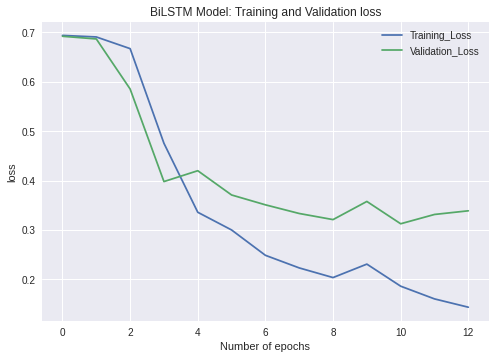

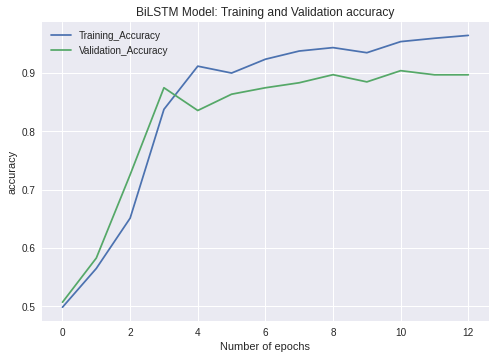

In [ ]:
# Create a dataframe
bilstm_metrics = pd.DataFrame(bilstm_history.history)

# Rename column
bilstm_metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs2(var1, var2, string):
    bilstm_metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs2('Training_Loss', 'Validation_Loss', 'loss')
plt.savefig('bilstm_loss.png')
plot_graphs2('Training_Accuracy', 'Validation_Accuracy', 'accuracy')
plt.savefig('bilstm_acc.png')

### Compare three different models
Based on loss, accuracy and the plots above, we can select Dense architecture as a final model for classifying the text messages. The Dense architecture model has validation accruacy of about 95% and loss of 0.12.

In [ ]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {dense_model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {lstm_model.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {bilstm_model.evaluate(testing_padded, test_labels)} " )

11/11 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9143
Dense architecture loss and accuracy: [0.21580331027507782, 0.9142857193946838] 
11/11 [==============================] - 0s 13ms/step - loss: 0.4077 - accuracy: 0.8770
LSTM architecture loss and accuracy: [0.40774527192115784, 0.877000093460083] 
11/11 [==============================] - 0s 12ms/step - loss: 0.3388 - accuracy: 0.8971
Bi-LSTM architecture loss and accuracy: [0.3387811779975891, 0.897095263004303] 


In [ ]:
#y=list()
y_pred = dense_model.predict(testing_padded)
y_dense = np.array([0 if x < 0.5 else 1 for x in y_pred[:,0]])
  #y.append()
#print(y)
confusion_matrix = classification_report(test_labels, y_dense)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       175
           1       0.94      0.89      0.91       175

    accuracy                           0.91       350
   macro avg       0.92      0.91      0.91       350
weighted avg       0.92      0.91      0.91       350



In [ ]:
from sklearn.metrics import confusion_matrix

#print(classification_report(test_labels,))

print(confusion_matrix(test_labels, y_dense))


[[165  10]
 [ 20 155]]


In [ ]:
y_pred = lstm_model.predict(testing_padded)
y_pred.reshape(np.shape(y_pred)[0],np.shape(y_pred)[1])
y_lstm = np.array([0 if x < 0.5 else 1 for x in y_pred[:,1]])

#print(y)
confusion_matrix1 = classification_report(test_labels, y_lstm)
print(confusion_matrix1)

              precision    recall  f1-score   support

           0       0.85      0.55      0.67       175
           1       0.67      0.90      0.77       175

    accuracy                           0.73       350
   macro avg       0.76      0.73      0.72       350
weighted avg       0.76      0.73      0.72       350



In [ ]:
from sklearn.metrics import confusion_matrix

#print(classification_report(test_labels,))

print(confusion_matrix(test_labels, y_lstm))


[[ 96  79]
 [ 17 158]]


In [ ]:
y_pred = bilstm_model.predict(testing_padded)
y_pred.reshape(np.shape(y_pred)[0],np.shape(y_pred)[1])
y_bilstm = np.array([0 if x < 0.5 else 1 for x in y_pred[:,1]])

#print(y)
confusion_matrix2 = classification_report(test_labels, y_bilstm)
print(confusion_matrix2)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       175
           1       0.92      0.82      0.86       175

    accuracy                           0.87       350
   macro avg       0.88      0.87      0.87       350
weighted avg       0.88      0.87      0.87       350



In [ ]:
from sklearn.metrics import confusion_matrix

#print(classification_report(test_labels,))

print(confusion_matrix(test_labels, y_bilstm))


[[162  13]
 [ 32 143]]


In [ ]:
from sklearn import metrics
y_1 = dense_model.predict(testing_padded)
y_2 = lstm_model.predict(testing_padded)
y_3 = bilstm_model.predict(testing_padded)
targets=test_labels
dist_fpr1, dist_tpr1, dist_thresh1 = metrics.roc_curve(targets, y_1[:,0], pos_label=1)
lstm_fpr1, lstm_tpr1, lstm_thresh1 = metrics.roc_curve(targets, y_2[:,0], pos_label=1)
bilstm_fpr1, bilstm_tpr1, bilstm_thresh1 = metrics.roc_curve(targets, y_3[:,0], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(targets))]
p_fpr, p_tpr, _ = metrics.roc_curve(targets, random_probs, pos_label=1)
auc_score1_dist = metrics.roc_auc_score(targets, y_1[:,0])
auc_score1_lstm = metrics.roc_auc_score(targets, y_2[:,0])
auc_score1_bilstm = metrics.roc_auc_score(targets, y_3[:,0])

In [ ]:
print(auc_score1_dist)
print(auc_score1_lstm)
print(auc_score1_bilstm)

0.9726040816326531
0.846465306122449
0.9592816326530612


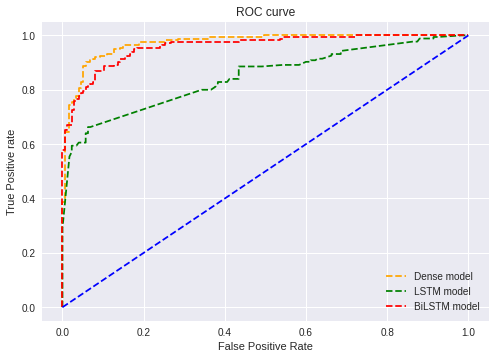

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(dist_fpr1, dist_tpr1, linestyle='--',color='orange', label='Dense model')
plt.plot(lstm_fpr1, lstm_tpr1, linestyle='--',color='green', label='LSTM model')
plt.plot(bilstm_fpr1, bilstm_tpr1, linestyle='--',color='red', label='BiLSTM model')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# Predict UCS from new data



In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["User selects a transformation language program file to parse.",
"The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time",
          "agentMom shall support the ability to send unicast message."]


In [ ]:
text=["The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time"]

In [ ]:
def predict_ucs(predict_msg,model):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    #model.predict_classes(padded)
    
    return (model.predict(padded))

In [ ]:
def get_predictions(text,model):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=max_len)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return np.argmax(prediction)

In [ ]:
text='User selects a transformation language program file to parse.'
print(get_predictions(predict_msg,bilstm_model))

0


In [ ]:
print(np.argmax(predict_spam(text,lstm_model)))

240


In [ ]:
p=predict_ucs(predict_msg,dense_model)
p

array([[0.99574834],
       [0.70416415],
       [0.00490552]], dtype=float32)

In [ ]:
p=predict_ucs(T,dense_model)
p

array([[0.03076181],
       [0.00180854],
       [0.8941301 ],
       [0.95434415]], dtype=float32)

Scenario 2: Using newly created text and see how the model classifies them. 
    
Below, first sentence is more like a spam whereas the rest of the two sentences are more like ham. 

In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["User selects a transformation language program file to parse.",
"The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time",
          "agentMom shall support the ability to send unicast message."]
p=predict_ucs(predict_msg,bilstm_model)
p.reshape(np.shape(p)[0],np.shape(p)[1])
y= np.array([0 if x < 0.5 else 1 for x in p[:,1]])
print(y)

[1 0 0]


In [ ]:
T=["Store assistant checks status of the tape to be returned by customer. ","PDF Split and Merge was created prior to this document, so all requirements stated here are already satisfied.","Cashier enters item identifier.",
"System updates the sale line item."]
p=predict_ucs(T,lstm_model)


In [ ]:
p[:,1]

array([[0.47915158],
       [0.48760226],
       [0.50205356],
       [0.55386144]], dtype=float32)

In [ ]:
p.reshape(np.shape(p)[0],np.shape(p)[1])
y1 = np.array([0 if x < 0.5 else 1 for x in p[:,1]])
print(y1)

[0 0 1 1]
